# Uncommon Words

Here I'm trying to find words in the dictionary that are not in common usage.

To overcome OCR issues, the list of definitions is cross-references against HathiTrust's OCR for two copies of this book: only definitions in this scan that also appear in the two OCR copies are kept. This will still leaves ample definitions.

To measure "uncommon", I cross-referenced the remaining list with the 700k most common words in the HathiTrust.

In [ ]:
import pandas as pd
from htrc_features import FeatureReader, utils
import numpy as np
from PIL import Image

path_pattern = '../data/pages/dictionary-{}.png'

In [ ]:
# Open data about the book, and the Bookworm wordlist
with pd.HDFStore('./dictionary.h5', mode='r') as store:
    definitions = store['/definitions']
    allp = store['/full']
    illustrations = store['/illustrations']
    
with pd.HDFStore('../data/wordlist.h5', mode='r') as store:
    final = store['final']

In [ ]:
definitions = definitions.groupby('word_group').filter(lambda x: (x.pagenum.max()-x.pagenum.min()) <= 1)

In [ ]:
definitions[definitions.text.str.contains('QUALITY', case=False)].text

63       ABSOLUTENESS (ab’so-liit-nes), n. Quality \n o...
71       ABSORBABILITY (ab-sarb-a-bil’i-ti), n. State \...
80       ABSTEMIOUSNESS (ab—ste’mi-us-nes), 11. \n Qual...
93       ABSTRACTIVE (ab-strakt’iv), a. Having the \n p...
95       ABSTRACTNESS (ab-strakt’nes), n. Quality \n or...
98       ABSTRUSENESS (ab-stros’nes), :1. Quality of \n...
100      ABSURDITY (ab-sﬁrd’i-ti), 11. [pk ABSURD’I- \n...
102      ABSUBDNESS (ab-silni‘ues), 1;. Quality of \n b...
110      ABUSIVENESS (a-bﬁ’siv-ncs), 11. Quality oi \n ...
114      -AC, sufﬁx. Pertaining to; having the quality ...
134      ACCEPTABILITY (ak-sept-a—bil’i-ti), n. Quality...
144      ACCESSIBILITY (ak-ses-l-bii’i-ti), 11. Quality...
151      ACCIDENT (ak’si—dent), n. 1. Undesigned, \n un...
205      ACCURACY (ak'ﬁ- \n ra-si), 11. Quality \n or s...
219      -ACEOUS {ft-shus), sufﬁx. Having the quality \...
223      ACESCENCE(a-ses’ens),ACESCENCYhs-ses’en- \n si...
233      ACETONE (as’e-tﬁn), n. Chemical reagent- \n so.

In [ ]:
definitions[['text']].iloc[1000:1010]

,text
1004,ALMA “LATER (al’ma ma’tér). The college or \n ...
1005,"ALMANAC (al’ma-nak), 72. Book with a calen- \n..."
1006,"ALMIGHTILY (al-rnit’i-Ii), adv. In an al- \n m..."
1007,"ALMIGHTINESS (aI-mjt’i-nes), 1:. Inﬁnite \n po..."
1008,"ALMIGHTY (al-niit’i), I. a. 1. Having un- \n l..."
1009,"ALMOND {Ewan-l), n. \n 1. Fruit of the 31»- \n..."
1010,"ALMONER (al’mun-Clr), \n n. Distributor of aims."
1011,"ALMONEY (al’mun-ri), \n In. Place Wherealms \n..."
1012,"ALMOST (a‘l’mést), mu- Almond \f’rlulus r m. \..."
1013,"ALMSHOUSE (iimz’hows), n. I‘oorhousc."


## Cull to clean words (appear in multiple OCR) and cross reference with top 700k English words

In [ ]:
# Two copies of the same dictionary, Laird and Lee's Webster's. They capitalize their words, so
# I'm looking for capital words that occur in both.
paths = ['../data/loc.ark+=13960=t3xs70k06.json.bz2', '../data/loc.ark+=13960=t84j1sb5j.json.bz2']
fr = FeatureReader(paths)
tokenlist = []
for vol in fr.volumes():
    tokenlist += vol.tokens()

tokens = pd.Series(tokenlist)
# Grab capitalized letters
dictionary_words = tokens[tokens.str.contains(r"^[A-Z][A-Z\-]*$")].value_counts()
shortlist = dictionary_words[dictionary_words > 1].index.str.lower().values

In [ ]:
unique_final_lower = final['token'].str.lower().unique()
unique_in_dicts = np.setdiff1d(shortlist, unique_final_lower[:700000])
has_def = definitions.query('word != ""')['word'].str.lower()
uncommonwords = pd.Series(np.intersect1d(has_def, unique_in_dicts))
uncommonwords.sample(10)

5155          sauced
6230       victualer
220     amphitropous
391      appellatory
1292        carburet
748         bebeerin
2450      desudation
5149    sarcophagous
3094    exaggerative
3625      hush-money
dtype: object

## Query for definitions, and find the image

In [ ]:
def query_definitions(q):
    # Remember that any query match should be expanded to the word_group
    match_groups = definitions.loc[definitions['word'] == q.upper(), "word_group"].values
    matches = definitions[definitions['word_group'].isin(match_groups.tolist())]
    return matches

match = query_definitions('dysorexy')
match

,word_group,col_group,pagenum,left,text,right,linenum,top,bottom,word,part
14213,13802,4,465,884,"DYSOREXY (dis’o-reks-i), n. Pathol. Bad or \n ...",1481,"(57, 59)",424,498,DYSOREXY,1


In [ ]:
_debug = True

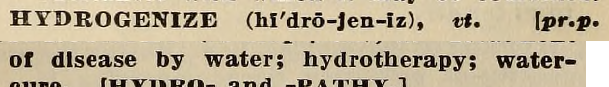

In [ ]:
def img_from_row(row, hpad=6, wpad=25):
    ''' Input: series'''
    path = path_pattern.format(row['pagenum'])
    img_file = Image.open(path)
    return img_file.crop((row['left']-wpad, row['top']-hpad, row['right']+wpad, row['bottom']+hpad))

def img_from_match(matches, hpad=6, wpad=25):
    ''' Potentially combine multiple rows'''
    if len(matches) == 1:
        img = img_from_row(matches.iloc[0], hpad=hpad, wpad=wpad)
        return img
    else:
        hsize = (matches['bottom'] - matches['top']).sum() + 2*hpad
        wsize = (matches['right'] - matches['left']).max() + 2*wpad

        new_im = Image.new('RGB', (wsize, hsize),
                           color=((0,0,255) if _debug else (255,255,255)))
        y_offset = 0

        for i, match in matches.iterrows():
            img = img_from_row(match, hpad, wpad)
            new_im.paste(img, (0, y_offset))
            y_offset += img.height
        return new_im

#for i in range(0,20):
#    word = uncommonwords.sample().values[0]
#    match = query_definitions(word)
#    img = img_from_match(match, hpad=0, wpad=0)
#    print(img.size[0])

word = uncommonwords.sample().values[0]
match = query_definitions('HYDROGENIZE')
img_from_match(match, 10, 10)

## Save all the 'Uncommon Words'

In [ ]:
i = len(uncommonwords)
for word in uncommonwords:
    match = query_definitions(word)
    img = img_from_match(match)
    img.save("../data/def_images/{}.png".format(word))
    i -= 1
    print(i)

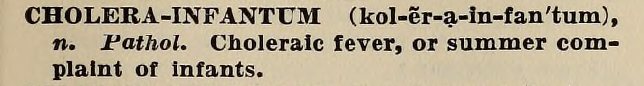

In [ ]:
# Test
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

## That's it!

### Testing: patch uncommon words into a page format

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps

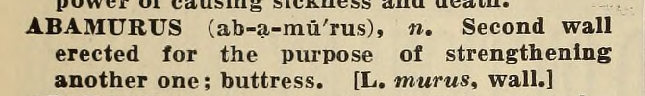

In [ ]:
test_images = []
widths = []
for word in uncommonwords.values[:20]:
    match = query_definitions(word)
    img = img_from_match(match)
    w,h = img.size
    if (w < 640) or (w > 652):
        continue
    test_images.append(img)
    widths.append(img.size[0])
test_images[0]

In [ ]:
match.word.values[0]

'LOVE-LOCK'

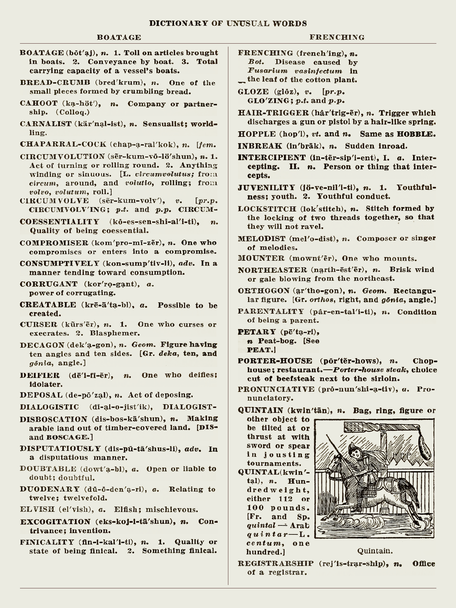

In [ ]:
def create_img_mask(img):
    imgb = ImageEnhance.Brightness(img)
    imgc = ImageEnhance.Contrast(imgb.enhance(1.3))
    imgmask = ImageOps.invert(imgc.enhance(3).convert('L'))
    return imgmask

margin = 60
sep_margin = margin
colwidth = 595
par_pad = 15
header_size = 70
wsize = int(margin*2 + colwidth*2+sep_margin)
hsize = int(wsize*4/3)
page_color = (235, 235, 225)
ink_color = (70,30,30)

im = Image.new('RGB', (wsize, hsize), color=page_color)
draw = ImageDraw.Draw(im)

# Add images
vplace_start = margin + header_size + 20
vplace = vplace_start
column = 0

draw = ImageDraw.Draw(im)
font = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", 30)

for word in uncommonwords.iloc[1000::100].values[:80]:
    match = query_definitions(word)
    img = img_from_match(match, hpad=0, wpad=0)
    w,h = img.size

    if (w > colwidth+5):
        continue
    elif (w < colwidth-15) & (h > 50):
        # If it's an under-width definition, create a version with an
        # illustration next it
        img_w_illust = Image.new('RGB', (colwidth, h),
                                  color=((255,0,0) if _debug else (255,255,255)))
        illust = Image.new('RGB', (colwidth-w-10, h),
                           color=((0,255,0) if _debug else (255,255,255)))
        img_w_illust.paste(img, (0, 0))
        img_w_illust.paste(illust, (w+10, 0))
        img = img_w_illust
        
    if (vplace+h) > (hsize-margin-10):
        vplace = vplace_start
        if column == 0:
            column += 1
        else:
            break
            column = 0
            # TODO save the page and start a new page
    imgmask = create_img_mask(img)
    im.paste(img, (margin+(column*(colwidth+sep_margin)), vplace), imgmask)
    
    # If at the top of a column, add column header
    if vplace == vplace_start:
        word = match.word.values[0]
        def_img = get_defword_img(img, word)
        def_img_mask = create_img_mask(def_img)
        im.paste(def_img,
                 (int((colwidth-def_img.width)/2+margin+(column*(colwidth+sep_margin))), 
                  int(margin+header_size-def_img.height-10)),
                def_img_mask)
        
    vplace += (h + par_pad)

im.paste(title_img,
         (int((wsize-title_img.width)/2), int(margin)),
        title_img_mask)

draw.line((colwidth+margin+sep_margin/2, margin + header_size + 10, colwidth+margin+sep_margin/2, hsize-margin-10), fill=ink_color)
draw.line((margin, margin + header_size, wsize-margin, margin + header_size), fill=ink_color)
draw.line((margin, hsize-margin, wsize-margin, hsize-margin), fill=ink_color)

#font = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", poem_fsize)

#ill_full = get_illustration()
#ill = ill_full.resize((int(illustration_height*(ill_full.size[0] / ill_full.size[1])),
#                      illustration_height),
#                      Image.ANTIALIAS)

#illmask = create_img_mask(ill)

im.resize((int(wsize/3),int(hsize/3)), Image.ANTIALIAS)

In [ ]:
_debug = not _debug

In [ ]:
# Section: One who or that
definitions[definitions.word.str.endswith('ER') & definitions.text.str.contains('one.*or that', case=False)]

,word_group,col_group,pagenum,left,text,right,linenum,top,bottom,word,part
355,344,0,41,195,"ADAPTER (a-dap’tér), n. 1. One who or that \n ...",790,"(12, 15)",332,433,ADAPTER,1
445,429,2,44,246,"ADOPTER (a-dopt’er), n. One who or that \n whi...",834,"(29, 30)",736,783,ADOPTER,1
1148,1117,3,63,868,"AMBLER (am’hlér), n. One who or that which \n ...",1466,"(75, 76)",233,276,AMBLER,1
1223,1190,4,66,899,"AMPLIFIER (am’pli-ﬁ-ér), n. One who or that \n...",1496,"(85, 86)",323,370,AMPLIFIER,1
1300,1266,2,68,237,"ANALYZER (an’a-li’z'ér), n. One who or that \n...",825,"(62, 64)",1569,1639,ANALYZER,1
1895,1840,6,84,251,"APPLIER (ap-pli’ér), n. One who or that which ...",841,"(58, 60)",1149,1227,APPLIER,1
2491,2419,3,106,900,"ATODIIZER (at’um-i—zér), \n n. One who or that...",1239,"(79, 84)",354,508,ATODIIZER,1
2572,2496,4,108,913,"ATTRACTER (at-trakt’i‘r), ATTRACTOR (at- \n tl...",1506,"(115, 116)",1196,1241,ATTRACTER,1
2983,2896,3,123,869,"BAFFLER (baf’lér), n. One who or that which \n...",1461,"(129, 130)",1576,1615,BAFFLER,1
3015,2926,2,125,182,"BAITER (bat’ér), n. One who or that which \n b...",776,"(20, 21)",429,472,BAITER,1


### Create Title Header Images

In [ ]:
words = [('DICTIONARY', (0,0,0,0)),
         ('OFT', (0,0,17,0)),
         ('UNARM', (0,0,63,0)),
         ('USUAL', (0,0,0,0)),
         ('WORD', (0,6,0,0)),
         ('SON ', (0,0,38,0))]
word_images = []
for word, cut_corners in words:
    match = definitions[definitions.text.str.startswith(word)][:1]
    img = img_from_match(match)
    def_img = get_defword_img(img, word)
    crop = cut_corners[:2] + ((def_img.width-cut_corners[2]), (def_img.height-cut_corners[3]))
    word_images.append(def_img.crop(crop))

titlew = sum([img.width for img in word_images]) + 30
titleh = max([img.height for img in word_images])

left = 0
title_img = Image.new('RGB', size=(titlew, titleh+2), color=(255, 255, 255))
top = [1, 2, 1, 1, 0, 1]
left_space = [10, 10, 0, 10, 0, 0]

for i, img in enumerate(word_images):
    title_img.paste(img, (left,top[i]))
    left += img.width + left_space[i]

title_img_mask = create_img_mask(title_img)
title_img

In [ ]:
# Testing 

In [ ]:
import pyocr
import pyocr.builders
tool = pyocr.get_available_tools()[0]
linebuilder = pyocr.builders.LineBoxBuilder()

def get_defword_img(def_img, query):
    line_boxes = tool.image_to_string(def_img, lang='eng', builder=linebuilder)
    words = [(wordbox.content, wordbox.position) for box in line_boxes for wordbox in box.word_boxes]
    pos = None
    for word in line_boxes:
        for wordbox in box.word_boxes:
            if wordbox.content == query:
                pos = wordbox.position
    # Fallback: return first wordbox
    if not pos:
        pos = line_boxes[0].word_boxes[0].position
    # Trim three pixels from the bottom
    return def_img.crop(pos[0]+pos[1])

In [ ]:
def draw_page(title, poem, style="book", page_num=False, annotate=False):
    

    wmargin=100
    hmargin=60
    toppos = 560
    page_color = (235, 235, 225)
    ink_color = (70,30,30)
    #annotate_color = (190,170,170)
    annotate_color = (205,180,180)
    illustration_height = 360
    title_fsize = 33
    poem_fsize = 28
    pnum_fsize = 22
    pnum_pad = 60
    line_spacing = 25
    annotation_pad = 10
    
    if style == "tweet":
        hsize = 1100
        wsize = 900
        wmargin=50
        hmargin=30
        toppos = 520

    im = Image.new('RGB', (wsize, hsize), color=page_color)
    draw = ImageDraw.Draw(im)
    
    annotation = "\n".join([word.replace("\n", "").capitalize() for word in title.split(' ')])
    
    # Size the poem
    j, k = 1, 1
    orig_wmargin=wmargin
    while True:
        font = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", poem_fsize)
        annotefont = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", poem_fsize)
        
        poemw, poemh = draw.textsize(poem, font=font)
        if annotate:
            annotw, annoth = draw.textsize(annotation, font=font)
            annotw += annotation_pad
        else:
            annotw = 0
            
        #Horizontal
        if (poemw + annotw) > (wsize-wmargin*2):
            if (j % 2 == 0) or (wmargin <= 10):
                poem_fsize -= 1
                title_fsize -= 1
            else:
                wmargin -= 4
            j += 1
            continue
        
        # vertical line spacing
        # Only start this after the font size has be figured out
        poemh = poemh + line_spacing*len(re.findall("\n",poem))
        if poemh > (hsize-toppos-hmargin*2):
            if line_spacing >= 2:
                line_spacing -= 3
    
            if (k % 5 == 0 and poem_fsize >= 16) or (k % 15 == 0):
                poem_fsize -= 1
                print(poem_fsize, k)
                # If changing the font size, the width will be affected
                if wmargin <= orig_wmargin:
                    wmargin += 2
            elif k % 5 == 1:
                if hmargin >= 3:
                    hmargin -= 3
            elif k % 2 == 0:
                if title_fsize >= 15:
                    title_fsize -= 3
                if toppos >= 300:
                    toppos -= 50
                if illustration_height >= 150:
                    illustration_height -= 50
                
            k += 1
            continue
            
        break
        
    # Size the title, by adding line breaks and resizing font
    while True:
        titlefont = ImageFont.truetype("../fonts/IMFePIrm28P.ttf", title_fsize)
        titlew, titleh = draw.textsize(title, font=titlefont)
        if titlew < (wsize-wmargin-40):
            break
        if len(re.findall('\n', title)) >= 2 and title_fsize > 10:
            title_fsize = title_fsize-1
        elif title_fsize <= 10:
            print("title_fsize", title_fsize)
        else:
            # Add line break
            locs = [m.start() for m in re.finditer(" ", title.split("\n")[0])]
            newlineloc=locs[math.ceil(len(locs)/2)]
            title = title[:newlineloc] + "\n" + title[newlineloc+1:]

    draw.line((wmargin*2, toppos, im.size[0]-wmargin*2, toppos), fill=ink_color)
    
    if hmargin >= :
        draw.line((wmargin*3, im.size[1]-hmargin, im.size[0]-wmargin*3, im.size[1]-hmargin), fill=ink_color)
    
    draw.multiline_text(((im.size[0]-titlew)/2, toppos-titleh-20),title,
                        ink_color,font=titlefont, align="center")

    draw.multiline_text(((im.size[0]-poemw+annotw)/2, toppos+hmargin),
                        poem,ink_color,
                        font=font, 
                        align="left",
                       spacing=line_spacing)
    
    if annotate:
        draw.multiline_text(((im.size[0]-poemw-annotw)/2, toppos+hmargin),
                            annotation,
                            annotate_color,
                            font=annotefont, 
                            align="right",
                           spacing=line_spacing)
    
    if page_num:
        pagenumfont = ImageFont.truetype("Lato-Regular.ttf", pnum_fsize)
        hpos = (im.size[0]-pnum_pad) if page_num % 2 == 1 else pnum_pad
        draw.text((hpos,im.size[1]-pnum_pad),
                  str(page_num),
                  font=pagenumfont,
                  fill=(0,0,0))
    
    # Add images
    ill_full = get_illustration()
    ill = ill_full.resize((int(illustration_height*(ill_full.size[0] / ill_full.size[1])),
                          illustration_height),
                          Image.ANTIALIAS)

    illmask = create_img_mask(ill)

    im.paste(ill,
             (int((im.size[0]-(ill.size[0]))/2), int((toppos-titleh-ill.size[1])/2)),
             illmask)

    return im

draw_page(title, poem, page_num=1).resize((450, 600), Image.ANTIALIAS)
#draw_page(title, poem, page_num=1, annotate=True, style="tweet").resize((270, 330), Image.ANTIALIAS)

SyntaxError: invalid syntax (<ipython-input-26-e48ea1276c2e>, line 102)

In [ ]:
illus